# Bicycle Crash analysis NEISS data 1999 to 2018
## National Electronic Injury Surveillance System

https://github.com/mrcorbett/MET_CS677_DataScienceWithPython/tree/master


"CPSC’s National Electronic Injury Surveillance System (NEISS) is a national probability sample of hospitals in the U.S. and its territories. Patient information is collected from each NEISS hospital for every emergency visit involving an injury associated with consumer products."

https://catalog.data.gov/dataset/cpscs-national-electronic-injury-surveillance-system-neiss
https://www.cpsc.gov/cgibin/NEISSQuery/home.aspx



In [ ]:
# Imports

import calendar
from code_id_translator import *
from datetime import datetime
import graphviz
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, fixed
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from neiss_backend_v8 import *
import numpy as np
import os
import pandas as pd
import pickle
import re
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz, plot_tree
import seaborn as sns
import sys
import xlrd



In [2]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [3]:
class Includes():
    TimingDiagrams = False
    PearsonChiSquared = True
    PythonCorr = True
    GaussianNB = True
    LinearRegressionChi2 = True


- Selection of geographic areas called primary sampling units (PSU) that are defined within sampling strata. 

https://www.cdc.gov/nchs/nhis/singleton_psu.htm

## Read the pickled neissYYYY.xlsx file

xlsx_to_pckl.ipynb is used to create the pickled file

In [4]:
neiss_pathname = os.getcwd() + '/data/NEISS'

pckl_fname = neiss_pathname + '/neiss_data.pckl'
if os.path.exists(pckl_fname):
    print("Reading {}  ... ".format(pckl_fname), end="")
    dfNeiss = pickle.load( open( pckl_fname, "rb" ) )
    print("done!")
else:
    raise Exception('ERROR:  {} does not exist'.format(pckl_fname))


Reading /Users/mcorbett/Boston University/MET_CS677_DataScienceWithPython/Project/data/NEISS/neiss_data.pckl  ... done!


In [5]:
dfNeiss.shape

(7352927, 19)

In [6]:
dfNeiss.head()

,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Other_Race,Body_Part,Diagnosis,Other_Diagnosis,Disposition,Location,Fire_Involvement,Product_1,Product_2,Narrative_1,Narrative_2,Stratum,PSU,Weight
0,100001,1999-12-24,41,2,1.0,0,31,71,NaN,1,0,0,3299,0,41 YR FEMALE FELL WHILE WALKING. DX: SEVERE MU...,/RIGHT BUTTOCKS & BACK.,S,71,68.1086
1,100002,1999-12-27,80,1,2.0,0,31,57,NaN,1,0,0,611,0,80 YR MALE FELL IN BATHROOM/HE HIT RIGHT RIBS ...,DX: FRACTURED RIGHT RIBS-UPPER TRUNK,S,71,68.1086
2,100003,1999-12-27,4,1,1.0,0,75,53,NaN,1,0,0,1328,0,4 YR MALE HAD METAL LARGE WAGON WHEEL FALL & H...,DX: CONTUSIN ON HEAD/NO LOC.,S,71,68.1086
3,100005,1999-12-28,18,1,0.0,NaN,94,53,NaN,1,0,0,1205,0,CONTUSION EAR - STRUCK IN RIGHT EAR WITH BASKE...,NaN,S,7,68.1086
4,100009,1999-12-28,19,2,0.0,NaN,92,64,NaN,1,0,0,5031,0,SPRAIN THUMB - INJURED THUMB WHEN SNOWBOARDING,NaN,S,7,68.1086


### Update Neiss with column code dictionary from Excel file

In [7]:
column_codes_fname = neiss_pathname + '/column_codes.xlsx'
column_dictionary = getColumnCodeDictionary(column_codes_fname)
Neiss.setColumnCodeDictionary(column_dictionary)

- Code to take the Neiss dictionaries for column codes and write them out to the column_codes.xlsx file.

In [8]:
neiss = Neiss(dfNeiss)

In [9]:
dfNeiss.shape

(7352927, 19)

### Time based graphs

- Preparation

In [10]:
date_name, stat_name = 'Treatment_Date', 'Sex'

#### Injuries Per Year

 Note:  The first graph requires the entire dataset.  The other time based graphs also utilize the entire dataset.

In [11]:
if True == Includes.TimingDiagrams:
    showInjuriesPerYear(dfNeiss, date_name, stat_name, 'Injuries Per Year')

#### Injuries Per 52 Weeks of the Year

In [12]:
if True == Includes.TimingDiagrams:
    showInjuriesPerMonthOfTheYear(dfNeiss, date_name, stat_name, 'Injuries Per 52 Weeks of the Year')

#### Injuries Per Month of the Year

In [13]:
if True == Includes.TimingDiagrams:
    showInjuriesPerMonthOfTheYear(dfNeiss, date_name, stat_name, 'Injuries Per Month of the Year')

#### Injuries Per Week of the Year

In [14]:
if True == Includes.TimingDiagrams:
    showInjuriesPerWeekOfTheYear(dfNeiss, date_name, stat_name, 'Injuries Per Week of the Year')

### PearsonChiSquared

https://machinelearningmastery.com/chi-squared-test-for-machine-learning/

'The Pearson’s chi-squared statistical hypothesis is an example of a test for independence between categorical variables.'

                                                                  translator
Function Category                                                           
codeToId Body_Part         [{0: 1, 30: 2, 31: 3, 32: 4, 33: 5, 34: 6, 35:...
         Diagnosis         [{41: 1, 42: 2, 46: 3, 48: 4, 49: 5, 50: 6, 51...
         Disposition                  [{1: 1, 2: 2, 4: 3, 5: 4, 6: 5, 9: 6}]
         Fire_Involvement                   [{0: 1, 1: 2, 2: 3, 3: 4, 4: 5}]
         Location          [{0: 1, 1: 2, 2: 3, 4: 4, 5: 5, 6: 6, 8: 7, 9:...
         PSU               [{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8:...
         Product_1         [{114: 1, 115: 2, 126: 3, 136: 4, 137: 5, 140:...
         Product_2         [{0: 1, 127: 2, 221: 3, 281: 4, 342: 5, 374: 6...
         Race                   [{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7}]
         Sex                                                  [{1: 1, 2: 2}]
         Stratum                  [{'C': 1, 'L': 2, 'M': 3, 'S': 4, 'V': 5}]

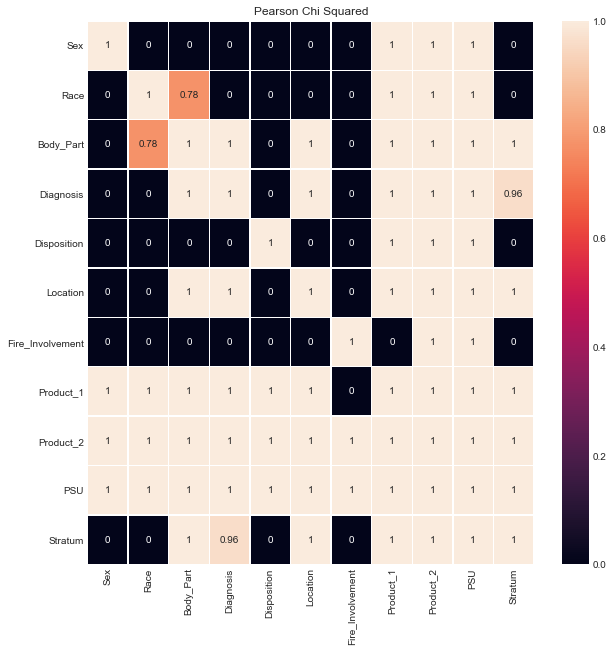

In [15]:
if True == Includes.PearsonChiSquared:
    # build the correlation matrix (contingency table)
    dfCategorical = dfNeiss.copy()
    categorical = ['Sex', 'Race', 'Body_Part', 'Diagnosis', 'Disposition', 'Location',
                   'Fire_Involvement', 'Product_1', 'Product_2', 'PSU', 'Stratum' ]
    dfCategorical = dfCategorical.xs(categorical, axis=1)
    dfCategorical.dropna(inplace=True)
    dfCategorical['Race'] = [int(x) for x in dfCategorical['Race']]
    dfCategorical = dfCategorical.sample(3000)
    #print('dfCategorical.head:\n{}'.format(dfCategorical.head()))

    codeIdTranslator = CodeIdTranslatorDataFrame(dfCategorical, categorical)
    #print(codeIdTranslator.state)
    codeIdTranslator.transformColumns()

    pcs1 = PearsonChiSquared(dfCategorical)
    dfCategoricalCorrMatrix = pcs1.getCorrMatrixDataframe(categorical)


    fig, ax = plt.subplots(figsize=(10, 10))

    #sns.heatmap(dfCorrMatrix, annot=True, mask=mask, fmt="d", linewidths=0.4, ax=ax)
    g = sns.heatmap(dfCategoricalCorrMatrix, annot=True, linewidths=0.4, ax=ax)
    g.set_title('Pearson Chi Squared')
    # Fix the top and bottom margins of the heatmap
    bottom_y, top_y = plt.ylim() 
    bottom_y += 0.5 
    top_y -= 0.5 
    plt.ylim(bottom_y, top_y)

    plt.show() 

### Python Corr

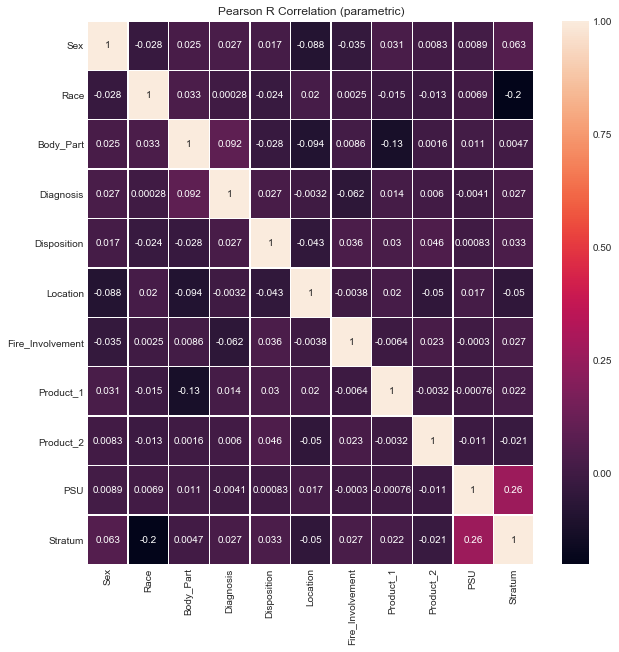

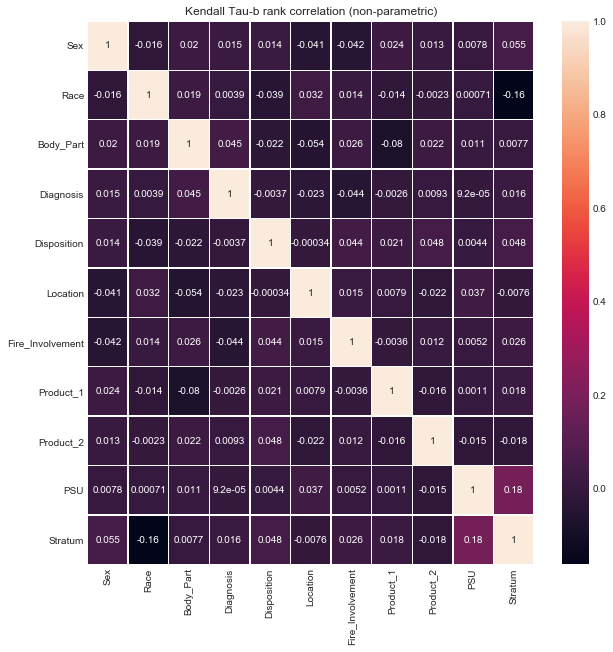

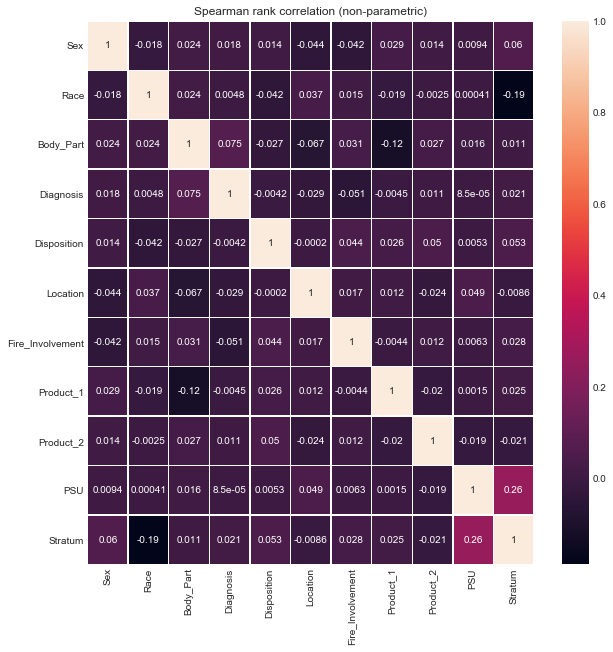

In [16]:
if True == Includes.PythonCorr:
    methods = {
        'pearson' : 'Pearson R Correlation (parametric)',  # not good for categorical data
            # For pearson:
            # both variables should be normally distributed
            # There should be no significant outliers
            # Each variable should be continuous
            # The two variables have a linear relationship
            # The observations are paired observations.
            # Should support homoscedascity.  Homoscedascity simply refers to ‘equal variances’.
        'kendall' : 'Kendall Tau-b rank correlation (non-parametric)',
            # The variables are measured on an ordinal or continuous scale.
            # Desirable if your data appears to follow a monotonic relationship.
        'spearman' : 'Spearman rank correlation (non-parametric)'
            # Does not assume that both datasets are normally distributed
        }


    for key in methods.keys():
        dfCategoricalPythonCorr = dfCategorical.corr(method = key)

        fig, ax = plt.subplots(figsize=(10, 10))

        g = sns.heatmap(dfCategoricalPythonCorr, annot=True, linewidths=0.4, ax=ax)
        g.set_title(methods[key])

        # Fix the top and bottom margins of the heatmap
        bottom_y, top_y = plt.ylim() 
        bottom_y += 0.5 
        top_y -= 0.5 
        plt.ylim(bottom_y, top_y)

        plt.show() 


In [17]:
#sns.pairplot(df)

In [18]:
def getHighCorrelations(df, dfCategoricalCorrMatrix, minValue):
    high_correlations = []
    for yIndex, y in enumerate(dfCategoricalCorrMatrix.index):
        for xIndex, x in enumerate(dfCategoricalCorrMatrix.columns):
            #if xIndex >= yIndex:
            #    break

            if (x != y) and (dfCategoricalCorrMatrix[y][x] > minValue):
                Y = y
                X = x
                if len(df[X].unique()) > len(df[Y].unique()):
                    # Keep the smallest item on the X axis
                    Y, X = X, Y
                    
                if (Y, X) not in high_correlations:
                    high_correlations.insert(-1, (Y, X))
    high_correlations.sort()
    return high_correlations

if True == Includes.PythonCorr:
    high_correlations = getHighCorrelations(dfCategorical, dfCategoricalCorrMatrix, 0.95)
    for n in high_correlations:
        print(n)

('Body_Part', 'Location')
('Body_Part', 'Stratum')
('Diagnosis', 'Body_Part')
('Diagnosis', 'Location')
('Diagnosis', 'Stratum')
('Location', 'Stratum')
('PSU', 'Body_Part')
('PSU', 'Diagnosis')
('PSU', 'Disposition')
('PSU', 'Fire_Involvement')
('PSU', 'Location')
('PSU', 'Race')
('PSU', 'Sex')
('PSU', 'Stratum')
('Product_1', 'Body_Part')
('Product_1', 'Diagnosis')
('Product_1', 'Disposition')
('Product_1', 'Location')
('Product_1', 'PSU')
('Product_1', 'Product_2')
('Product_1', 'Race')
('Product_1', 'Sex')
('Product_1', 'Stratum')
('Product_2', 'Body_Part')
('Product_2', 'Diagnosis')
('Product_2', 'Disposition')
('Product_2', 'Fire_Involvement')
('Product_2', 'Location')
('Product_2', 'PSU')
('Product_2', 'Race')
('Product_2', 'Sex')
('Product_2', 'Stratum')


In [19]:

if True == Includes.PythonCorr:
    button = widgets.Button(description="Click Me!")
    output = widgets.Output()

    #print(high_correlations.values)
    select = high_correlations[0]
    #print(select)
    lCorrelations = ['{}, {}'.format(y, x) for y, x in high_correlations]
    correlationDropDownSel = widgets.Dropdown(
        options=lCorrelations,
        value=lCorrelations[0],
        description='correlations',
        disabled=False,
    )

    typeDropDownSel = widgets.Dropdown(
        options=['swarm', 'scatter'],
        value='swarm',
        description='plot_type',
        disabled=False,
    )

    wHBox = widgets.HBox([correlationDropDownSel, typeDropDownSel])
    wVBox = widgets.VBox([wHBox, button, output])

    display(wVBox)

    def on_button_clicked(b):
        with output:
            sel = correlationDropDownSel.value
            (xSel, ySel) = [x.strip() for x in sel.split(',')]
            print('-{}-, -{}-'.format(xSel, ySel))

            correlations(codeIdTranslator, xSel, ySel, typeDropDownSel.value)

            #sns.pairplot(dfSel, hue=xSel)
    button.on_click(on_button_clicked)


## SKLearn - Gaussian Naive Bayes (GaussianNB)


Can perform online updates to model parameters via partial_fit method. 

For details on algorithm used to update feature means and variance online, 

see Stanford CS tech report STAN-CS-79-773 by Chan, Golub, and LeVeque:


http://i.stanford.edu/pub/cstr/reports/cs/tr/79/773/CS-TR-79-773.pdf


In [20]:
if True == Includes.GaussianNB:
    currentState = codeIdTranslator.getState()
    codeIdTranslator.setState('id')
    dfCorrelationsId = codeIdTranslator.getDataFrame().copy()
    codeIdTranslator.setState('code')
    dfCorrelationsCode = codeIdTranslator.getDataFrame().copy()
    codeIdTranslator.setState(currentState)


In [21]:
if True == Includes.GaussianNB:
    df1 = dfCorrelationsCode.copy()

    le = {}

    for col in df1.columns:
        le[col] = preprocessing.LabelEncoder()
        le[col].fit(df1[col].unique())
        print('{0:12s} => {1}'.format(col, le[col].classes_))
        df1[col] = le[col].transform(df1[col])

    df1

Sex          => [1 2]
Race         => [0 1 2 3 4 5 6]
Body_Part    => [ 0 30 31 32 33 34 35 36 37 38 75 76 77 79 80 81 82 83 84 85 87 88 89 92
 93 94]
Diagnosis    => [41 42 46 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68
 69 70 71 72 73 74]
Disposition  => [1 2 4 5 6 9]
Location     => [0 1 2 4 5 6 8 9]
Fire_Involvement => [0 1 2 3 4]
Product_1    => [ 114  115  126  136  137  140  214  215  216  219  224  231  260  263
  264  268  273  276  278  279  281  342  365  367  374  379  380  381
  413  417  419  428  431  435  438  450  460  463  464  466  469  474
  478  480  519  546  550  552  557  566  572  573  574  601  604  606
  609  611  612  620  627  628  648  649  652  654  661  666  670  676
  679  687  693  694  707  804  809  814  819  827  828  831  832  835
  836  837  841  845  852  854  855  856  857  859  862  869  870  871
  872  881  884  885  886  893  895  896  899  909  910  913  921  930
  934  949  954  955  956  960  964  976  983 1103 1107 1112

In [22]:
if True == Includes.GaussianNB:
    outputFeature = 'Diagnosis'

    categories = categorical.copy()
    categories.remove(outputFeature)

    df2 = dfCorrelationsId
    for category in categories:
        print(category, end=' - ')

        inputFeature = [category]

        # Train classifier
        gnb = GaussianNB()
        gnb.fit(
            df2[inputFeature].values,
            df2[outputFeature]
        )

        y_pred = gnb.predict(dfCorrelationsId[inputFeature])
        #print(y_pred)

        # Print results
        print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
              .format(
                  df2.shape[0],
                  (df2[outputFeature] != y_pred).sum(),
                  100*(1-(df2[outputFeature] != y_pred).sum()/df2.shape[0])
        ))

        pd.DataFrame(
            {'predicted': le[outputFeature].inverse_transform(y_pred),
             'actual':    df2[outputFeature]})

        #print(metrics.confusion_matrix(y_pred, df2[outputFeature]))


Sex - Number of mislabeled points out of a total 3000 points : 2997, performance 00.10%
Race - Number of mislabeled points out of a total 3000 points : 2764, performance 07.87%
Body_Part - Number of mislabeled points out of a total 3000 points : 2534, performance 15.53%
Disposition - Number of mislabeled points out of a total 3000 points : 2903, performance 03.23%
Location - Number of mislabeled points out of a total 3000 points : 2892, performance 03.60%
Fire_Involvement - Number of mislabeled points out of a total 3000 points : 2385, performance 20.50%
Product_1 - Number of mislabeled points out of a total 3000 points : 2350, performance 21.67%
Product_2 - Number of mislabeled points out of a total 3000 points : 2879, performance 04.03%
PSU - Number of mislabeled points out of a total 3000 points : 2395, performance 20.17%
Stratum - Number of mislabeled points out of a total 3000 points : 2598, performance 13.40%


In [23]:
if True == Includes.GaussianNB:
    # Drop categories with low scores
    categories1 = categories.copy()
    categories1.remove('Sex')
    categories1.remove('Disposition')
    categories1.remove('Location')
    categories1.remove('Product_2')
    categories1.remove('Stratum')

In [24]:
if True == Includes.GaussianNB:
    df2A = df2.copy()

In [25]:
if True == Includes.GaussianNB:
    df2A.drop(['Sex', 'Disposition', 'Location', 'Product_2', 'Stratum'], axis=1, inplace=True)

In [26]:
if True == Includes.GaussianNB:
    print(df2A.shape)

    #print(df2A.headcategories1
    print('InputFeatures=', categories1)

    for category in categories1:
        print("----------------------------")
        print(category)
        print()

        inputFeature = [category]

        # Train classifier
        gnb = GaussianNB()
        gnb.fit(
            df2A[inputFeature].values,
            df2A[outputFeature]
        )

        y_pred = gnb.predict(dfCorrelationsId[inputFeature])
        print(y_pred)

        # Print results
        print(df2A.shape)
        print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
              .format(
                  df2A.shape[0],
                  (df2A[outputFeature] != y_pred).sum(),
                  100*(1-(df2A[outputFeature] != y_pred).sum()/df2A.shape[0])
        ))
        pd.DataFrame(
            {'predicted': le[outputFeature].inverse_transform(y_pred),
             'actual':    df2A[outputFeature]})

        # df2A[outputFeature] has 29 unique values.  That is why there are 29 columns
        print(metrics.confusion_matrix(y_pred, df2A[outputFeature]))


(3000, 6)
InputFeatures= ['Race', 'Body_Part', 'Fire_Involvement', 'Product_1', 'PSU']
----------------------------
Race

[ 3 25  3 ... 15 15 25]
(3000, 6)
Number of mislabeled points out of a total 3000 points : 2764, performance 07.87%
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  5   1   2   2   1   1   7   6  73   0   5  13  55   5  92   3   0  32
    6  78   2   0   1   7   0   1  45   2   0   2]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   

Number of mislabeled points out of a total 3000 points : 2350, performance 21.67%
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  

## Linear regression (using chi2)

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

- f_classif:  ANOVA F-value between label/feature for classification tasks.

- mutual_info_classif: Mutual information for a discrete target.

- chi2:  Chi-squared stats of non-negative features for classification tasks.

- f_regression:  F-value between label/feature for regression tasks.

- mutual_info_regression:  Mutual information for a continuous target.
    
- SelectPercentile:  Select features based on percentile of the highest scores.

- SelectFpr:  Select features based on a false positive rate test.

- SelectFdr:  Select features based on an estimated false discovery rate.

- SelectFwe:  Select features based on family-wise error rate.

- GenericUnivariateSelect:  Univariate feature selector with configurable mode.


In [27]:
from sklearn import datasets
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2, f_regression, mutual_info_regression
from sklearn.feature_selection import SelectPercentile, SelectFpr, SelectFdr, SelectFwe, GenericUnivariateSelect
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score, scorer

In [28]:
if True == Includes.LinearRegressionChi2:
    dfKBest = df2.copy()

    y = dfKBest[outputFeature]
    selector = SelectKBest(chi2, k=3)
    selector.fit(dfKBest[categories].values, y)
    selector.get_support()

    print(categories)
    print(selector.get_support())
    selected_columns = np.asarray(categories)[selector.get_support()]
    print(selected_columns)
    print(selector.scores_)

['Sex', 'Race', 'Body_Part', 'Disposition', 'Location', 'Fire_Involvement', 'Product_1', 'Product_2', 'PSU', 'Stratum']
[False False  True False False False  True  True False False]
['Body_Part' 'Product_1' 'Product_2']
[7.09628676e+00 1.90853829e+01 1.68889250e+03 6.21573136e+01
 2.25546037e+02 1.24244921e+01 6.50738130e+03 8.07599216e+03
 6.94134948e+02 3.56098018e+01]


In [29]:
if True == Includes.LinearRegressionChi2:
    X = dfKBest[selected_columns]
    print(X.shape)

(3000, 3)


In [30]:
def plot_scatter(X,Y,R=None):
    plt.scatter(X, Y, s=32, marker='o', facecolors='none', edgecolors='k')
    if R is not None:
        plt.scatter(X, R, color='red', linewidth=0.5)
    plt.show()    


x= Body_Part


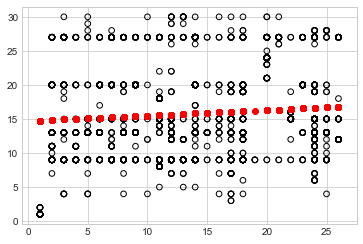

R-squared score: 0.0084


x= Product_1


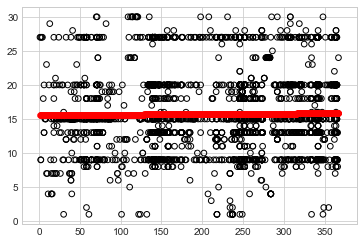

R-squared score: 0.0002


x= Product_2


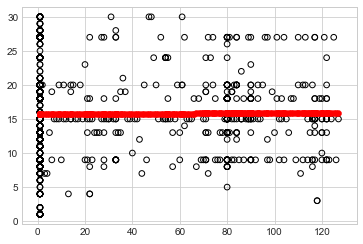

R-squared score: 0.0000




In [31]:
if True == Includes.LinearRegressionChi2:
    for category in X:
        print('x=', category)
        x = np.asarray(dfKBest[category]).reshape(-1, 1)
        regressor = LinearRegression(normalize=True).fit(x, y)
        y_pred    = regressor.predict(x)
        plot_scatter(x, y, y_pred)
        print("R-squared score: {:.4f}".format(r2_score(y, y_pred)))
        print()
        print()


## Decision Tree

In [32]:
def replaceValueWithStringInColumn(column_name, replace_value, with_string):
    dfDecisionTree[column_name] = [
            with_string if str(x) == '{}'.format(replace_value) else x 
            for x in dfDecisionTree[column_name]]  # Replace zeros in col='disposition' with 'Unknown'


In [33]:
def checkForNumericValueInColumn(columnName):
    for index, value in enumerate(dfDecisionTree[columnName]):
        if type(value) == int:
            if 'Treatment_Date' in dfDecisionTree.columns:
                print('{}: Found int={} at {} - {}'.format(
                    columnName, value, index, dfDecisionTree['Treatment_Date'].iloc[index]))
            else:
                print('{}: Found int={} at {}'.format(columnName, value, index))
                


In [82]:
def createOnHotEncodedDataframe(df):
    '''
    Take columns that are objects and turn them into multiple one-hot columns.

    Args:
        df    (pd.DataFrame):  The dataframe to convert to a one-hot dataframe

    Returns:
        dfOneHot (pd.DataFrame):  A dataframe with the original objects replaced with one-hot versions.


    Example dataframe:

        Cost(dollars)  Item
        2              'Baseball'
        5              'Baseball Glove'
        7              'Helmet'

    Will become a dataframe similar to:

        Cost(dollars)  ('Item', 'Baseball')    ('Item', 'Baseball Glove')  ('Item', 'Helmet)
        2              1                       0                           0
        5              0                       1                           0
        7              0                       0                           1

    By making a tuple for the column header it is easy to determine the variable that the one-hot
    column represents.
    '''
    dfOneHot = df.copy()

    updateFreq = 100
    print('Dots are printed every {} translations'.format(updateFreq))

    for col in df.columns:
        if df[col].dtype == object:
            print('Transforming {:20s}'.format(col), end='\t')

            unique = pd.unique(df[col].sort_values(ascending=True))
            nUnique = len(unique)
            print('nUnique={}'.format(nUnique), end='\t')

            updateIndex = updateFreq
            updateNext = updateFreq

            for index, value in enumerate(unique):
                if index == updateIndex:
                    updateIndex += updateFreq
                    updateNext += updateFreq
                    print('.', end='')
                    
                dfOneHot[(col, value)] = (dfOneHot[col] == value).astype(int)
            dfOneHot.drop(columns=[col], inplace=True)
            print('\tcomplete')
    return dfOneHot


In [51]:

dfNeissDecisionTree = neiss.getDataFrame().copy()

# Remove columns containing NaN or columns where the number of unique items is greater than 
toBeDropped = []
for col in dfNeissDecisionTree.columns:
    if dfNeissDecisionTree[col].isnull().values.any():
        toBeDropped.append(col)

# Also remove the case number and the narrative
toBeDropped.extend(['CPSC_Case_Number', 'Narrative_1'])

# The following dates contain codes that do not match the column_codes table.
#dfNeissDecisionTree = dfNeissDecisionTree[dfNeissDecisionTree['Treatment_Date'].dt.year != 1999]
#dfNeissDecisionTree = dfNeissDecisionTree[dfNeissDecisionTree['Treatment_Date'].dt.year != 2000]
#dfNeissDecisionTree = dfNeissDecisionTree[dfNeissDecisionTree['Treatment_Date'].dt.year != 2001]
#dfNeissDecisionTree = dfNeissDecisionTree[dfNeissDecisionTree['Treatment_Date'].dt.year != 2002]
#dfNeissDecisionTree = dfNeissDecisionTree[dfNeissDecisionTree['Treatment_Date'].dt.year != 2003]
#dfNeissDecisionTree = dfNeissDecisionTree[dfNeissDecisionTree['Treatment_Date'].dt.year != 2004]
#dfNeissDecisionTree = dfNeissDecisionTree[dfNeissDecisionTree['Treatment_Date'].dt.year != 2005]
#dfNeissDecisionTree = dfNeissDecisionTree[dfNeissDecisionTree['Treatment_Date'].dt.year != 2006]
#dfNeissDecisionTree = dfNeissDecisionTree[dfNeissDecisionTree['Treatment_Date'].dt.year != 2007]
#dfNeissDecisionTree = dfNeissDecisionTree[dfNeissDecisionTree['Treatment_Date'].dt.year != 2008]
#dfNeissDecisionTree = dfNeissDecisionTree[dfNeissDecisionTree['Treatment_Date'].dt.year != 2009]
#dfNeissDecisionTree = dfNeissDecisionTree[dfNeissDecisionTree['Treatment_Date'].dt.year != 2010]
#dfNeissDecisionTree = dfNeissDecisionTree[dfNeissDecisionTree['Treatment_Date'].dt.year != 2011]
#dfNeissDecisionTree = dfNeissDecisionTree[dfNeissDecisionTree['Treatment_Date'].dt.year != 2012]
dfNeissDecisionTree = dfNeissDecisionTree[
    ~dfNeissDecisionTree['Treatment_Date'].dt.year.isin(list(range(1999, 2013)))]

#toBeDropped.extend(['Treatment_Date'])
dfNeissDecisionTree.drop(toBeDropped, axis=1, inplace=True)

# Remove values that do not have column codes for them
dfNeissDecisionTree = dfNeissDecisionTree[~dfNeissDecisionTree['Product_1'].isin([1841, 1903])]
dfNeissDecisionTree = dfNeissDecisionTree[~dfNeissDecisionTree['Product_2'].isin([1841, 1903])]

dfNeissDecisionTree['mDate'] = mdates.date2num(dfNeissDecisionTree['Treatment_Date']) 
dfNeissDecisionTree.drop(['Treatment_Date'], axis=1, inplace=True)

#dfDecisionTree = Neiss.translateCodes(dfNeissDecisionTree[0 : len(dfNeissDecisionTree) // 4])  # Use 1/4 the data
dfDecisionTree = Neiss.translateCodes(dfNeissDecisionTree[0 : len(dfNeissDecisionTree) // 2])  # Use 1/2 the data
#dfDecisionTree = Neiss.translateCodes(dfNeissDecisionTree)


replaceValueWithStringInColumn('Product_1', 0, 'Zero') # Keep the zero.
replaceValueWithStringInColumn('Product_2', 0, 'Zero') # Especially for Product_2.
replaceValueWithStringInColumn('Fire_Involvement', 4, 'InvalidCode')


for col in dfDecisionTree.columns:
    print('{:20s}\tnunique={}\tnum_nulls={}\ttype={}'.format(
        col,
        dfDecisionTree[col].nunique(),
        dfDecisionTree[col].isnull().sum(),
        dfDecisionTree[col].dtype))

print('Done')

Age                 	nunique=130	num_nulls=0	type=int64
Sex                 	nunique=3	num_nulls=0	type=object
Body_Part           	nunique=26	num_nulls=0	type=object
Diagnosis           	nunique=30	num_nulls=0	type=object
Disposition         	nunique=7	num_nulls=0	type=object
Location            	nunique=9	num_nulls=0	type=object
Fire_Involvement    	nunique=4	num_nulls=0	type=object
Product_1           	nunique=786	num_nulls=0	type=object
Product_2           	nunique=724	num_nulls=0	type=object
Stratum             	nunique=5	num_nulls=0	type=object
PSU                 	nunique=88	num_nulls=0	type=int64
Weight              	nunique=51	num_nulls=0	type=float64
mDate               	nunique=1113	num_nulls=0	type=float64
Done


In [52]:
#checkForNumericValueInColumn('Disposition')
checkForNumericValueInColumn('Fire_Involvement')
checkForNumericValueInColumn('Product_1')
checkForNumericValueInColumn('Product_2')

print('Done')

Done


In [83]:
dfOneHot = createOnHotEncodedDataframe(dfDecisionTree)
#print('len=', len(dfOneHot.columns))

yLabels = []
for col in dfOneHot.columns:
    if col[0] == 'Diagnosis':
        yLabels.append(col)

#print('len(yLabels)=', len(yLabels))
#print('yLabels =', yLabels)
#print()
#print(dfOneHot.columns)
#print(yLabels)
xLabels = [value for value in dfOneHot.columns if value not in yLabels]
#print('len(xLabels)=', len(xLabels))
#print('xLabels =', xLabels)
#print()

x = dfOneHot[xLabels]
y = dfOneHot[yLabels]



Dots are printed every 100 translations
Transforming Sex                 	nUnique=3		complete
Transforming Body_Part           	nUnique=26		complete
Transforming Diagnosis           	nUnique=30		complete
Transforming Disposition         	nUnique=7		complete
Transforming Location            	nUnique=9		complete
Transforming Fire_Involvement    	nUnique=4		complete
Transforming Product_1           	nUnique=786	.......	complete
Transforming Product_2           	nUnique=724	.......	complete
Transforming Stratum             	nUnique=5		complete


In [85]:
clfDecisionTree = DecisionTreeClassifier() # gini is the default criterion
#clfDecisionTree = DecisionTreeClassifier(criterion="entropy")
clfDecisionTreeFit = clfDecisionTree.fit(x, y)
print(clfDecisionTreeFit)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


- ***** 
- Full data model accuracy
- ***** 

In [86]:
y_pred = clfDecisionTreeFit.predict(x)
y_pred

# Model accuracy
metrics.accuracy_score(y, y_pred)

0.9992456198804307

In [ ]:
# This code generates the following error for some reason:
#    Error: neiss_2013_2018: syntax error in line 743 near ','

#dot_data=export_graphviz(clfDecisionTreeFit, out_file=None, 
#                     feature_names=xLabels,  # inputs
#                     class_names=yLabels, # outputs 
#                     filled=True, rounded=True,   
#                     special_characters=True)  
#graph = graphviz.Source(dot_data) 
#graph.render("neiss_2013_2018")

In [ ]:
#!open neiss_2013_2018.pdf

- ***** 
- Now with 70% training set, 30% testing set
- ***** 

In [ ]:
bu_id = 7286

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=bu_id)

clfGini = DecisionTreeClassifier()
clfGiniFit = clfGini.fit(X_train, y_train)
print(clfGiniFit)

y_pred = clfGiniFit.predict(X_test)
# print(y_pred)

# Model accuracy
print(metrics.accuracy_score(y_test, y_pred))
